# Basic data imformation

## 1 load libraries

Changes Made:
Treating newest_veh_age as a Categorical Column:
When the value is -20, it is labeled as "Non-Auto".
For other values, a label like "Age_8" is used (indicating age 8, for example).
This change makes newest_veh_age a categorical feature, which allows you to use it directly in your predictive models without losing the distinction for non-auto policies.
Why This Approach?
It explicitly separates "non-auto" policies from auto policies based on the vehicle's age.
It retains the original values for vehicle age and makes it clear that a distinct category exists for policies without vehicles.
It avoids introducing numeric ambiguity by mixing ages with a special value.
Let me know if this meets your needs or if you want to make further adjustments!

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import Neccessary libraries
import numpy as np
import pandas as pd

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

#Import Sampler libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

# Set the decimal format
pd.options.display.float_format = "{:.2f}".format

## 2 load csv data and basic analysis

When first load csv, data, it shows there is a mismatch in the number of columns, so this step is find the mitmatch data and deal with these rows

In [110]:
cleaned_lines = []

with open('train_data.csv', 'r') as file:
    for line_num, line in enumerate(file):
        fields = line.strip().split(',')
        if len(fields) == 21:  # Because 21 is the correct number of columns
            cleaned_lines.append(line)
        else:
            if len(fields) > 21:
                cleaned_lines.append(','.join(fields[:21]))
            else:
                continue

with open('cleaned_train_data.csv', 'w') as cleaned_file:
    cleaned_file.write("\n".join(cleaned_lines))

### 2.1 see the basic data information and type

In [111]:
data = pd.read_csv('cleaned_train_data.csv', delimiter=',')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       80000 non-null  int64  
 1   12m_call_history         80000 non-null  int64  
 2   acq_method               80000 non-null  object 
 3   ann_prm_amt              80000 non-null  float64
 4   bi_limit_group           80000 non-null  object 
 5   channel                  80000 non-null  object 
 6   digital_contact_ind      80000 non-null  int64  
 7   geo_group                80000 non-null  object 
 8   has_prior_carrier        80000 non-null  int64  
 9   home_lot_sq_footage      80000 non-null  int64  
 10  household_group          80000 non-null  object 
 11  household_policy_counts  80000 non-null  int64  
 12  newest_veh_age           80000 non-null  int64  
 13  pay_type_code            80000 non-null  object 
 14  pol_edeliv_ind        

In [112]:
data.head()

,id,12m_call_history,acq_method,ann_prm_amt,bi_limit_group,channel,digital_contact_ind,geo_group,has_prior_carrier,home_lot_sq_footage,...,household_policy_counts,newest_veh_age,pay_type_code,pol_edeliv_ind,prdct_sbtyp_grp,product_sbtyp,telematics_ind,tenure_at_snapshot,trm_len_mo,call_counts
0,1,3,missing,669.21,NonAuto,Others,1,suburban,0,57249,...,1,-20,type1,1,B,type1,-2,0,12,27
1,2,0,method4,606.45,NonAuto,Retail,1,urban,0,133481,...,1,-20,type1,1,A,type1,-2,71,12,0
2,3,0,method2,677.06,SPGrp1Miss,Retail,0,urban,0,18540,...,2,8,type3,0,A,type3,1,18,6,0
3,4,0,method2,1317.32,NonAuto,Retail,0,urban,0,63624,...,1,-20,type1,0,B,type1,-2,59,12,29
4,5,0,method3,2238.37,SPGrp1Miss,Retail,0,suburban,1,4867,...,2,55,type1,0,A,type1,0,24,6,25


### 2.2 data type changing

#### 2.2.1 column(object to int) : call_counts

In [113]:
#####call_counts should be int but the type result is objectk=, then check wthe non-numeric value in 'call_counts'###
non_numeric_counts = data[pd.to_numeric(data['call_counts'], errors='coerce').isna() & data['call_counts'].notna()]

# Display rows with non-numeric values in 'call_counts'
print("Non-numeric values in 'call_counts':")
print(non_numeric_counts)


Non-numeric values in 'call_counts':
Empty DataFrame
Columns: [id, 12m_call_history, acq_method, ann_prm_amt, bi_limit_group, channel, digital_contact_ind, geo_group, has_prior_carrier, home_lot_sq_footage, household_group, household_policy_counts, newest_veh_age, pay_type_code, pol_edeliv_ind, prdct_sbtyp_grp, product_sbtyp, telematics_ind, tenure_at_snapshot, trm_len_mo, call_counts]
Index: []

[0 rows x 21 columns]


In [114]:
#### change the target vairiable data type
data['call_counts'] = data['call_counts'].astype(str)
data = data[~data['call_counts'].str.contains("rural", na=False)]

#Convert 'call_counts' to numeric, replacing errors with NaN, and then to integer
data['call_counts'] = pd.to_numeric(data['call_counts'], errors='coerce').fillna(0).astype(int)
print(data['call_counts'].dtype)

int32


#### 2.2.2 column (object to int): tenure_at_snapshot

In [115]:
### acoording to the logic, tenure_at snapshot should also be int
# Identify and display non-numeric values in 'tenure_at_snapshot'
non_numeric_tenure = data[pd.to_numeric(data['tenure_at_snapshot'], errors='coerce').isna() & data['tenure_at_snapshot'].notna()]
print("Non-numeric values in 'tenure_at_snapshot':")
print(non_numeric_tenure)
###there is no non-numeric values, so do the transformation directly

data['tenure_at_snapshot'] = pd.to_numeric(data['tenure_at_snapshot'], errors='coerce').fillna(0).astype(int)
print(data['tenure_at_snapshot'].dtype)

Non-numeric values in 'tenure_at_snapshot':
Empty DataFrame
Columns: [id, 12m_call_history, acq_method, ann_prm_amt, bi_limit_group, channel, digital_contact_ind, geo_group, has_prior_carrier, home_lot_sq_footage, household_group, household_policy_counts, newest_veh_age, pay_type_code, pol_edeliv_ind, prdct_sbtyp_grp, product_sbtyp, telematics_ind, tenure_at_snapshot, trm_len_mo, call_counts]
Index: []

[0 rows x 21 columns]
int32


#### 2.2.3 column(int to object) : pol_edeliv_ind

In [116]:
# Convert 'pol_edeliv_ind' from integer to object (string)
data['pol_edeliv_ind'] = data['pol_edeliv_ind'].astype(str)

# Confirm the conversion was successful
print(data['pol_edeliv_ind'].dtype)


object


#### 2.2.4 column(int to object) : digital_contact_ind

In [117]:
data['digital_contact_ind'] = data['digital_contact_ind'].astype(str)

print(data['digital_contact_ind'].dtype)


object


#### 2.2.6 column(int to object) : has_prior_carrier

In [118]:
data['has_prior_carrier'] = data['has_prior_carrier'].astype(str)

print(data['has_prior_carrier'].dtype)


object


#### deal with special problem
Beacuse the output of distict columns of telematics_ind will print the same category in different rows, so we also need to deal with it

In [119]:
##when fist count telematics_ind column, if might have different data types or may include invisible characters
#This can cause Pandas to treat them as distinct values,We should clean up the values in the telematics_ind column to ensure consistency.
#So the solution is:
#remove any accidental spaces around the values.
#Convert All Values to a Consistent Data Type: We’ll ensure all values are treated as strings or integers, as needed.

data['telematics_ind'] = data['telematics_ind'].astype(str).str.strip()
unique_values = data['telematics_ind'].value_counts()


###2.3 Identify categorical columns and deal with missing value

In [120]:
# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Create a summary DataFrame for each categorical column
summary_dfs = []

for col in categorical_columns:
    # Create a DataFrame for the current column's value counts
    col_summary = data[col].value_counts().reset_index()
    col_summary.columns = [col, 'count']

    # Store the result
    summary_dfs.append(col_summary)

# Display each column's summary
for summary_df in summary_dfs:
    print(f"Unique values and counts for column: {summary_df.columns[0]}")
    print(summary_df)
    print("\n" + "-"*50 + "\n")


Unique values and counts for column: acq_method
  acq_method  count
0    missing  16066
1    method4  16039
2    method3  16029
3    method1  15984
4    method2  15882

--------------------------------------------------

Unique values and counts for column: bi_limit_group
  bi_limit_group  count
0        NonAuto  58015
1        CSLGrp1   3192
2         SPGrp3   3155
3        CSLGrp3   3146
4         SPGrp2   3145
5         SPGrp4   3138
6     SPGrp1Miss   3115
7        CSLGrp2   3094

--------------------------------------------------

Unique values and counts for column: channel
  channel  count
0  Retail  52888
1  Others  27112

--------------------------------------------------

Unique values and counts for column: digital_contact_ind
  digital_contact_ind  count
0                   0  50718
1                   1  29282

--------------------------------------------------

Unique values and counts for column: geo_group
  geo_group  count
0     urban  26795
1  suburban  26646
2     ru

Deal with missing value by using KNN to predict

In [121]:
###########################################################################
###########  Deal with missing value for acq_method column #######
###########################################################################
# Normalization on numeric variables
numerical_columns = ['12m_call_history', 'ann_prm_amt','home_lot_sq_footage','tenure_at_snapshot','newest_veh_age','trm_len_mo','household_policy_counts','call_counts']


# Data Splitting, valid and invalid acq_method

data_with_acq_info = data[data['acq_method'] != 'missing']
data_without_acq_info = data[data['acq_method'] == 'missing']

# Select numerical columns as features for K-NN
X_train = data_with_acq_info[numerical_columns]
y_train = data_with_acq_info['acq_method']
X_test = data_without_acq_info[numerical_columns]


# Initialize and train K-NN
knn = KNeighborsClassifier(n_neighbors=5)  # Set 'k' value
knn.fit(X_train, y_train)

# Predict acq information for 'missing ' rows
predicted_acq_method = knn.predict(X_test)

# Update the predicted_acq_method column with predicted values
data.loc[data['acq_method'] == 'missing', 'acq_method'] = predicted_acq_method


In [122]:
###########################################################################
###########  Deal with missing value for pol_edeliv_ind column #######
###########################################################################
# Normalization on numeric variables
numerical_columns = ['12m_call_history', 'ann_prm_amt','home_lot_sq_footage','tenure_at_snapshot','newest_veh_age','trm_len_mo','household_policy_counts']


# Data Splitting, valid and invalid pol_edeliv_method

data_with_pol_edeliv_info = data[data['pol_edeliv_ind'] != '-2']
data_without_pol_edeliv_info = data[data['pol_edeliv_ind'] == '-2']

# Select numerical columns as features for K-NN
X_train = data_with_pol_edeliv_info[numerical_columns]
y_train = data_with_pol_edeliv_info['pol_edeliv_ind']
X_test = data_without_pol_edeliv_info[numerical_columns]


# Initialize and train K-NN
knn = KNeighborsClassifier(n_neighbors=5)  # Set 'k' value
knn.fit(X_train, y_train)

# Predict pol_edeliv information for 'missing ' rows
predicted_pol_edeliv_method = knn.predict(X_test)

# Update the predicted_pol_edeliv_method column with predicted values
data.loc[data['pol_edeliv_ind'] == '-2','pol_edeliv_ind'] = predicted_pol_edeliv_method

In [123]:
# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Create a summary DataFrame for each categorical column
summary_dfs = []

for col in categorical_columns:
    # Create a DataFrame for the current column's value counts
    col_summary = data[col].value_counts().reset_index()
    col_summary.columns = [col, 'count']

    # Store the result
    summary_dfs.append(col_summary)

# Display each column's summary
for summary_df in summary_dfs:
    print(f"Unique values and counts for column: {summary_df.columns[0]}")
    print(summary_df)
    print("\n" + "-"*50 + "\n")


Unique values and counts for column: acq_method
  acq_method  count
0    method1  21415
1    method2  20276
2    method3  19615
3    method4  18694

--------------------------------------------------

Unique values and counts for column: bi_limit_group
  bi_limit_group  count
0        NonAuto  58015
1        CSLGrp1   3192
2         SPGrp3   3155
3        CSLGrp3   3146
4         SPGrp2   3145
5         SPGrp4   3138
6     SPGrp1Miss   3115
7        CSLGrp2   3094

--------------------------------------------------

Unique values and counts for column: channel
  channel  count
0  Retail  52888
1  Others  27112

--------------------------------------------------

Unique values and counts for column: digital_contact_ind
  digital_contact_ind  count
0                   0  50718
1                   1  29282

--------------------------------------------------

Unique values and counts for column: geo_group
  geo_group  count
0     urban  26795
1  suburban  26646
2     rural  26559

--------

### 2.5 Identify numeric columns



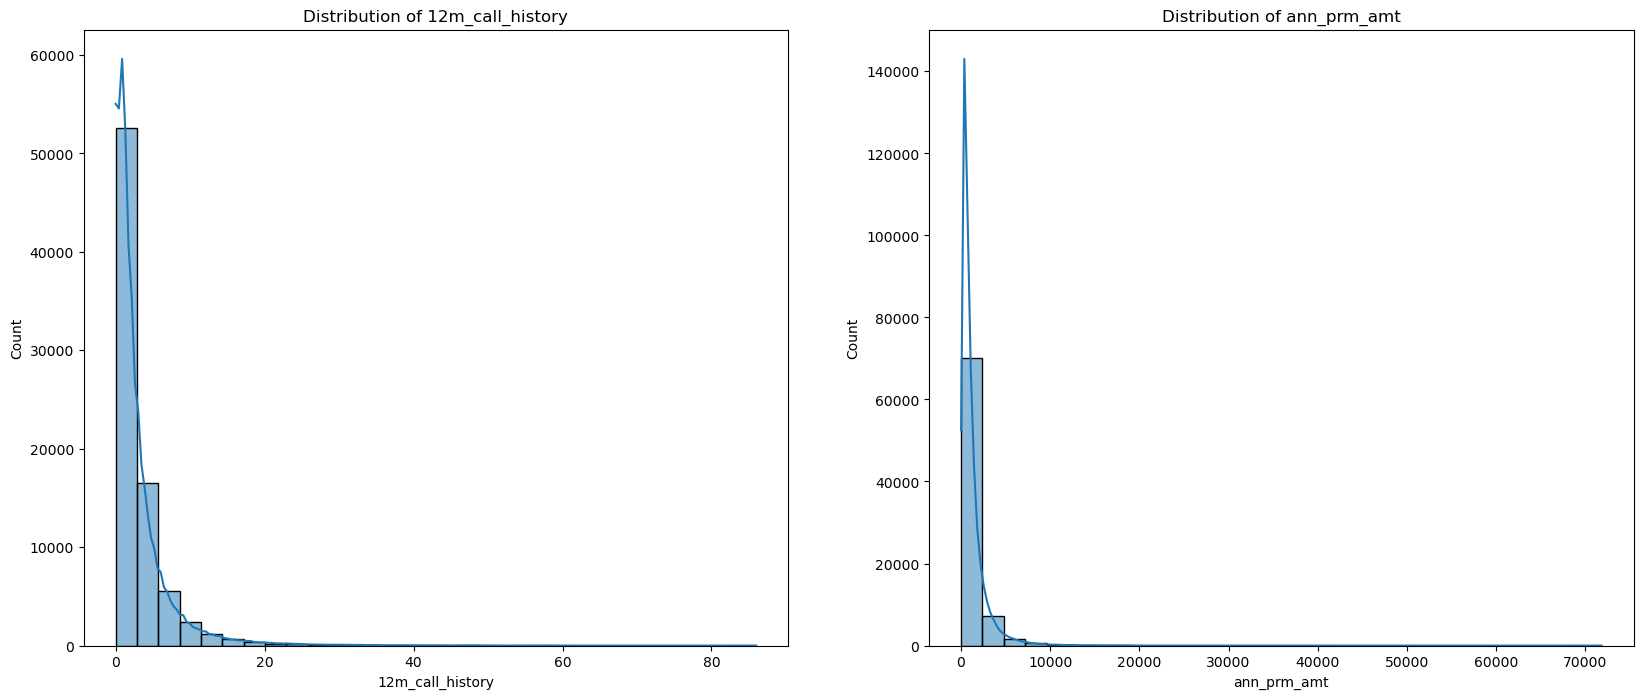

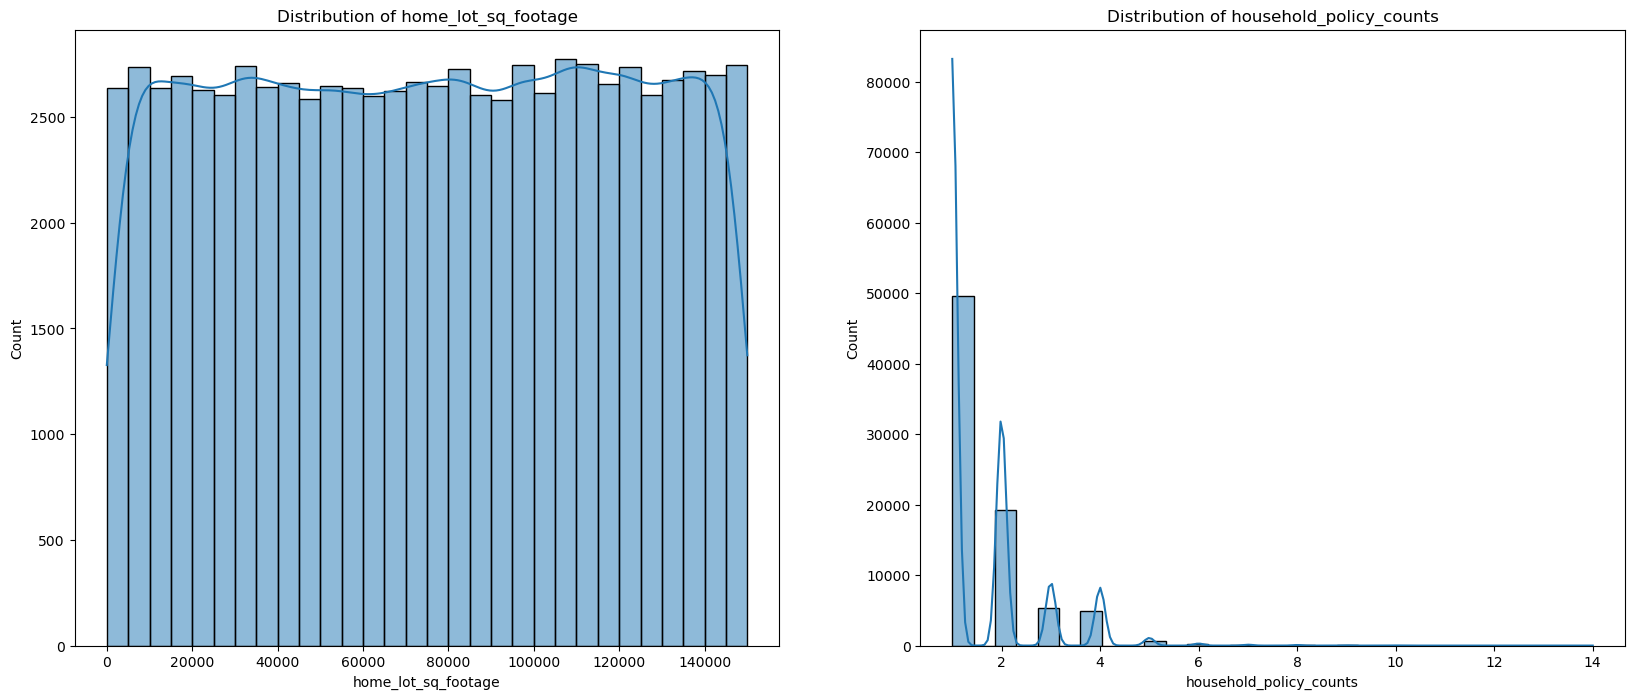

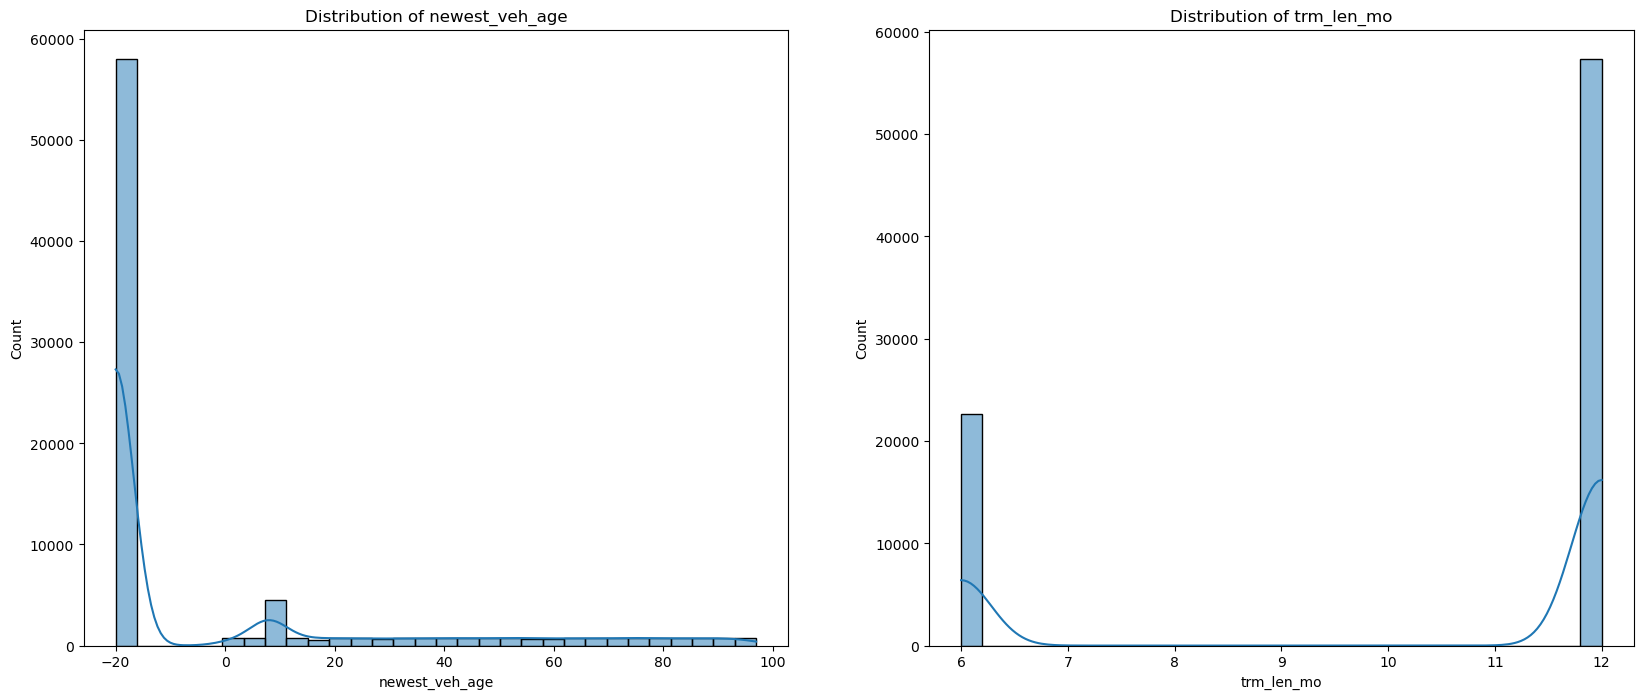

<Figure size 640x480 with 0 Axes>

In [124]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.drop('id')
# Loop through numerical columns and create side-by-side visualizations
i = 0
while i < len(numerical_cols):
    plt.figure(figsize=(20, 8))

    # First subplot
    plt.subplot(1, 2, 1)
    sns.histplot(data[numerical_cols[i]], kde=True, bins=30)
    plt.title(f'Distribution of {numerical_cols[i]}')

    i += 1
    if i >= len(numerical_cols):
        break

    # Second subplot
    plt.subplot(1, 2, 2)
    sns.histplot(data[numerical_cols[i]], kde=True, bins=30)
    plt.title(f'Distribution of {numerical_cols[i]}')

    i += 1
    plt.show()

plt.savefig('numerical_visualization.png')

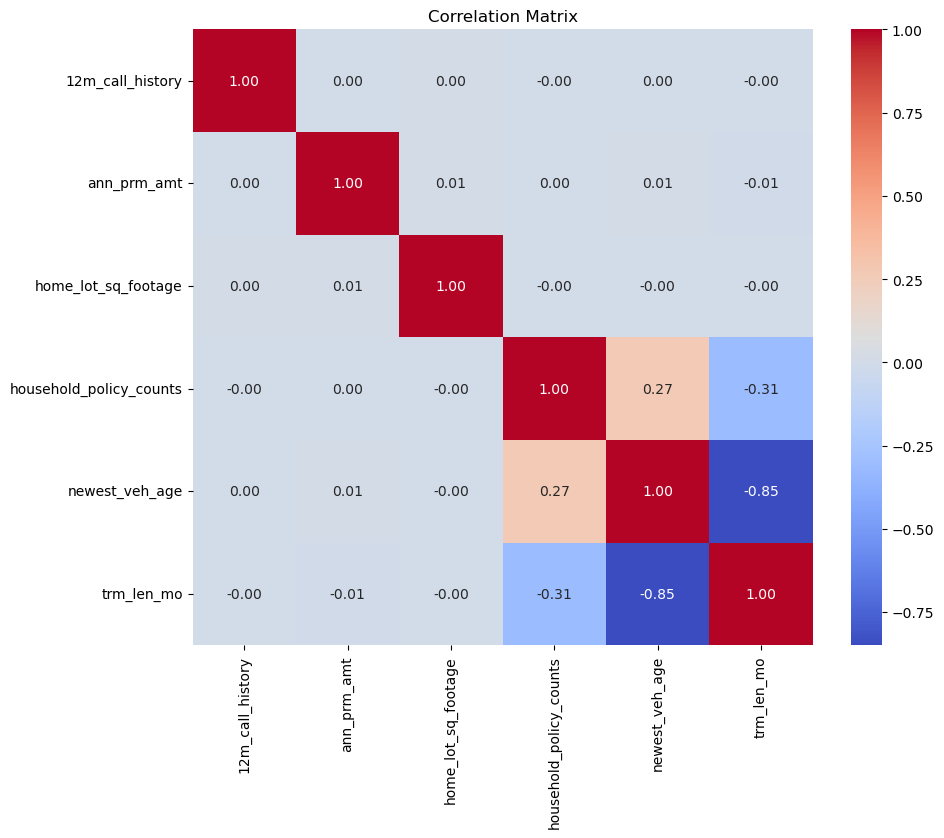

In [125]:
# 确保 'numerical_cols' 中不包含 'id' 列
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.drop('id')

plt.figure(figsize=(10, 8))
sns.heatmap(data[numerical_cols].corr(), annot=True, fmt='.2f', cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()


In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       80000 non-null  int64  
 1   12m_call_history         80000 non-null  int64  
 2   acq_method               80000 non-null  object 
 3   ann_prm_amt              80000 non-null  float64
 4   bi_limit_group           80000 non-null  object 
 5   channel                  80000 non-null  object 
 6   digital_contact_ind      80000 non-null  object 
 7   geo_group                80000 non-null  object 
 8   has_prior_carrier        80000 non-null  object 
 9   home_lot_sq_footage      80000 non-null  int64  
 10  household_group          80000 non-null  object 
 11  household_policy_counts  80000 non-null  int64  
 12  newest_veh_age           80000 non-null  int64  
 13  pay_type_code            80000 non-null  object 
 14  pol_edeliv_ind        

## 3 Cleaning data

In [18]:
'''# Step 2: Replace 'missing' string values in categorical columns with a new category 'Missing'
categorical_columns = ['acq_method', 'bi_limit_group', 'channel', 'geo_group', 'household_group',
                       'pay_type_code', 'prdct_sbtyp_grp', 'product_sbtyp']
for col in categorical_columns:
    train_data[col] = train_data[col].replace('missing', 'Missing')

# Step 3: Handle 'newest_veh_age' by creating a separate category for non-auto policies
# Convert the -20 value to a new category 'Non-Auto' and treat it as categorical
data['newest_veh_age'] = data['newest_veh_age'].apply(
    lambda x: 'Non-Auto' if x == -20 else 'Age_' + str(int(x))
)

# Step 4: Impute other numerical missing values (if any) with median
numerical_columns = ['ann_prm_amt', 'home_lot_sq_footage', 'tenure_at_snapshot']
imputer = SimpleImputer(strategy='median')
train_data[numerical_columns] = imputer.fit_transform(train_data[numerical_columns])

# Step 5: Convert indicator columns with special codes to binary
indicator_columns = ['digital_contact_ind', 'pol_edeliv_ind', 'telematics_ind']
for col in indicator_columns:
    train_data[col] = train_data[col].replace(-2, 0)  # Replacing special codes with default value (0) for simplicity

# Step 6: Save the cleaned dataset
train_data.to_csv('final_cleaned_train_data.csv', index=False)

print("Data cleaning with separate category for non-auto policies completed successfully!")'''

'# Step 2: Replace \'missing\' string values in categorical columns with a new category \'Missing\'\ncategorical_columns = [\'acq_method\', \'bi_limit_group\', \'channel\', \'geo_group\', \'household_group\',\n                       \'pay_type_code\', \'prdct_sbtyp_grp\', \'product_sbtyp\']\nfor col in categorical_columns:\n    train_data[col] = train_data[col].replace(\'missing\', \'Missing\')\n\n# Step 3: Handle \'newest_veh_age\' by creating a separate category for non-auto policies\n# Convert the -20 value to a new category \'Non-Auto\' and treat it as categorical\ndata[\'newest_veh_age\'] = data[\'newest_veh_age\'].apply(\n    lambda x: \'Non-Auto\' if x == -20 else \'Age_\' + str(int(x))\n)\n\n# Step 4: Impute other numerical missing values (if any) with median\nnumerical_columns = [\'ann_prm_amt\', \'home_lot_sq_footage\', \'tenure_at_snapshot\']\nimputer = SimpleImputer(strategy=\'median\')\ntrain_data[numerical_columns] = imputer.fit_transform(train_data[numerical_columns])\n\

### 3.1 Create two new datasets for auto and non-auto
because we want to build a model to predict the call counts per policy, so we categorize and split the dataset into these four different categories based on the household_group column,

In [54]:
df_1dwelling = data[data['household_group'] == '1dwelling']
df_2autodwelling = data[data['household_group'] == '2autodwelling']
df_3other = data[data['household_group'] == '3other']
df_3autodwellingumb = data[data['household_group'] == '3autodwellingumb']

# Print the shape of each DataFrame to confirm the split
print(f"1dwelling: {df_1dwelling.shape}")
print(f"2autodwelling: {df_2autodwelling.shape}")
print(f"3other: {df_3other.shape}")
print(f"3autodwellingumb: {df_3autodwellingumb.shape}")

1dwelling: (49073, 21)
2autodwelling: (20155, 21)
3other: (8942, 21)
3autodwellingumb: (1830, 21)


In [56]:
# For '1dwelling'
df_1dwelling_nonauto = df_1dwelling[df_1dwelling['newest_veh_age'] == -20]
df_1dwelling_auto = df_1dwelling[df_1dwelling['newest_veh_age'] != -20]

# For '2autodwelling'
df_2autodwelling_nonauto = df_2autodwelling[df_2autodwelling['newest_veh_age'] == -20]
df_2autodwelling_auto = df_2autodwelling[df_2autodwelling['newest_veh_age'] != -20]

# For '3other'
df_3other_nonauto = df_3other[df_3other['newest_veh_age'] == -20]
df_3other_auto = df_3other[df_3other['newest_veh_age'] != -20]

# For '3autodwellingumb'
df_3autodwellingumb_nonauto = df_3autodwellingumb[df_3autodwellingumb['newest_veh_age'] == -20]
df_3autodwellingumb_auto = df_3autodwellingumb[df_3autodwellingumb['newest_veh_age'] != -20]

# Step 3: Print the shapes to confirm the splits
print(f"1dwelling - Non-Auto: {df_1dwelling_nonauto.shape}, Auto: {df_1dwelling_auto.shape}")
print(f"2autodwelling - Non-Auto: {df_2autodwelling_nonauto.shape}, Auto: {df_2autodwelling_auto.shape}")
print(f"3other - Non-Auto: {df_3other_nonauto.shape}, Auto: {df_3other_auto.shape}")
print(f"3autodwellingumb - Non-Auto: {df_3autodwellingumb_nonauto.shape}, Auto: {df_3autodwellingumb_auto.shape}")

1dwelling - Non-Auto: (49073, 21), Auto: (0, 21)
2autodwelling - Non-Auto: (0, 21), Auto: (20155, 21)
3other - Non-Auto: (8942, 21), Auto: (0, 21)
3autodwellingumb - Non-Auto: (0, 21), Auto: (1830, 21)


In [57]:
import pandas as pd

df_auto = pd.concat([df_2autodwelling_auto, df_3autodwellingumb_auto])
df_non_auto = pd.concat([df_1dwelling_nonauto, df_3other_nonauto])
df_non_auto = df_non_auto[df_non_auto['newest_veh_age'] != 20]


print(f"Auto group shape: {df_auto.shape}")
print(f"Non-Auto group shape: {df_non_auto.shape}")


Auto group shape: (21985, 21)
Non-Auto group shape: (58015, 21)


In [58]:
####useful for auto feature selection#####
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Define a function to preprocess the data
def preprocess_data(df):
    # Handle missing values for specific columns
    non_numeric_columns = df.select_dtypes(include=['object']).columns
    for col in non_numeric_columns:
        df[col] = df[col].replace('missing', np.nan)  # Replace 'missing' with NaN
        df[col].fillna(df[col].mode()[0], inplace=True)  # Fill NaN with mode

    # One-hot encode categorical columns
    df = pd.get_dummies(df, drop_first=True)

    # Ensure all columns are numeric
    assert all(df.dtypes != 'object'), "Not all columns are numeric"

    return df

# Preprocess the auto group
df_auto_processed = preprocess_data(df_auto)

# Separate features (X) and target (y) for the auto group
X_auto = df_auto_processed.drop(columns=['call_counts', 'id'], errors='ignore')  # Adjust based on your column names
y_auto = df_auto_processed['call_counts']

# Function to perform feature selection and train the model
def train_model(X, y):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Perform Recursive Feature Elimination (RFE)
    rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)
    X_rfe_train = rfe.fit_transform(X_train, y_train)  # Transform training set
    X_rfe_test = rfe.transform(X_test)  # Transform test set

    # Get selected features and save to list
    selected_features_auto = X.columns[rfe.support_].tolist()  # Save the selected features in a list
    print("Selected Features for Auto Group:", selected_features_auto)

    # Train final model on selected features
    final_model = RandomForestClassifier(random_state=42)
    final_model.fit(X_rfe_train, y_train)

    # Predict and evaluate
    y_pred = final_model.predict(X_rfe_test)
    print("Model Accuracy for Auto Group:", accuracy_score(y_test, y_pred))
    print("\nClassification Report for Auto Group:\n", classification_report(y_test, y_pred))

    # Return the selected features list
    return selected_features_auto

# Train and evaluate the model for the auto group
print("Training model for Auto group:")
selected_features_auto = train_model(X_auto, y_auto)

# The list of selected features can now be used
print("Selected Features for Auto Group (saved in a list):", selected_features_auto)



Training model for Auto group:
Selected Features for Auto Group: ['12m_call_history', 'ann_prm_amt', 'home_lot_sq_footage', 'household_policy_counts', 'newest_veh_age', 'tenure_at_snapshot', 'geo_group_urban', 'has_prior_carrier_1', 'prdct_sbtyp_grp_C', 'telematics_ind_0']
Model Accuracy for Auto Group: 0.4810097793950421

Classification Report for Auto Group:
               precision    recall  f1-score   support

           0       0.49      0.99      0.65      2138
           1       0.00      0.00      0.00        38
           2       0.00      0.00      0.00        35
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00        33
           5       0.00      0.00      0.00        22
           6       0.00      0.00      0.00        34
           7       0.00      0.00      0.00        27
           8       0.00      0.00      0.00        30
           9       0.00      0.00      0.00        22
          10       0.00      0.00      0.

In [59]:
####useful for non_auto feature selection#####
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Define a function to preprocess the data
def preprocess_data(df):
    # Handle missing values for specific columns
    non_numeric_columns = df.select_dtypes(include=['object']).columns
    for col in non_numeric_columns:
        df[col] = df[col].replace('missing', np.nan)  # Replace 'missing' with NaN
        df[col].fillna(df[col].mode()[0], inplace=True)  # Fill NaN with mode

    # One-hot encode categorical columns
    df = pd.get_dummies(df, drop_first=True)

    # Ensure all columns are numeric
    assert all(df.dtypes != 'object'), "Not all columns are numeric"

    return df

# Preprocess the auto group
df_non_auto_processed = preprocess_data(df_non_auto)

# Separate features (X) and target (y) for the auto group
X_non_auto = df_non_auto_processed.drop(columns=['call_counts', 'id'], errors='ignore')  # Adjust based on your column names
y_non_auto = df_non_auto_processed['call_counts']

# Function to perform feature selection and train the model
def train_model(X, y):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Perform Recursive Feature Elimination (RFE)
    rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)
    X_rfe_train = rfe.fit_transform(X_train, y_train)  # Transform training set
    X_rfe_test = rfe.transform(X_test)  # Transform test set

    # Get selected features and save to list
    selected_features_non_auto = X.columns[rfe.support_].tolist()  # Save the selected features in a list
    print("Selected Features for Non Auto Group:", selected_features_non_auto)

    # Train final model on selected features
    final_model = RandomForestClassifier(random_state=42)
    final_model.fit(X_rfe_train, y_train)

    # Predict and evaluate
    y_pred = final_model.predict(X_rfe_test)
    print("Model Accuracy for Non Auto Group:", accuracy_score(y_test, y_pred))
    print("\nClassification Report for Non Auto Group:\n", classification_report(y_test, y_pred))

    # Return the selected features list
    return selected_features_non_auto

# Train and evaluate the model for the auto group
print("Training model for Non Auto group:")
selected_features_non_auto = train_model(X_non_auto, y_non_auto)

# The list of selected features can now be used
print("Selected Features for Non Auto Group (saved in a list):", selected_features_non_auto)


Training model for Non Auto group:
Selected Features for Non Auto Group: ['12m_call_history', 'ann_prm_amt', 'home_lot_sq_footage', 'household_policy_counts', 'tenure_at_snapshot', 'channel_Retail', 'digital_contact_ind_1', 'geo_group_urban', 'has_prior_carrier_1', 'prdct_sbtyp_grp_B']
Model Accuracy for Non Auto Group: 0.48987330862707923

Classification Report for Non Auto Group:
               precision    recall  f1-score   support

           0       0.51      0.97      0.67      5852
           1       0.00      0.00      0.00        73
           2       0.00      0.00      0.00        75
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00        72
           6       0.00      0.00      0.00        89
           7       0.00      0.00      0.00        80
           8       0.00      0.00      0.00        63
           9       0.00      0.00      0.00        80
          10       

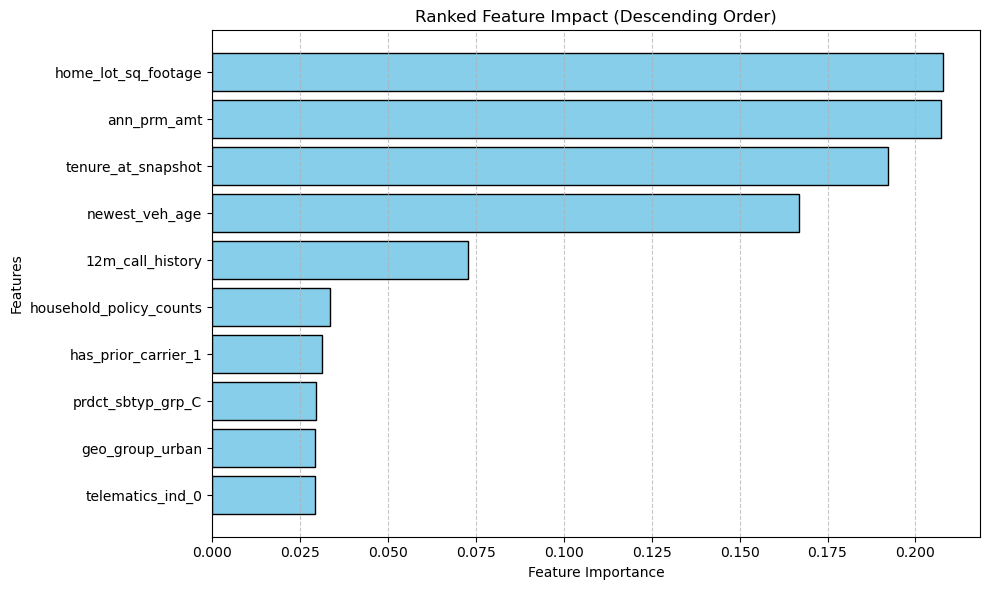

In [131]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Function to plot ranked feature impact
def plot_sorted_feature_impact(X, y, selected_features):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Select only the important features
    X_train_selected = X_train[selected_features]
    
    # Train the Random Forest model
    final_model = RandomForestClassifier(random_state=42)
    final_model.fit(X_train_selected, y_train)
    
    # Get feature importances
    feature_importances = final_model.feature_importances_
    
    # Combine feature names and their importance into a DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)  # Sort by importance in descending order
    
    # Create a bar plot for sorted feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue', edgecolor='black')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Ranked Feature Impact (Descending Order)')
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest importance on top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage
plot_sorted_feature_impact(X_auto, y_auto, selected_features_auto)



Training model for Auto group using Clustering:
Selected Features for Auto Group: ['12m_call_history', 'ann_prm_amt', 'home_lot_sq_footage', 'household_policy_counts', 'newest_veh_age', 'tenure_at_snapshot', 'geo_group_urban', 'has_prior_carrier_1', 'prdct_sbtyp_grp_C', 'telematics_ind_0']
Train RMSE: 36.9910
Test RMSE: 38.0147
Train R2: 0.0353
Test R2: 0.0357


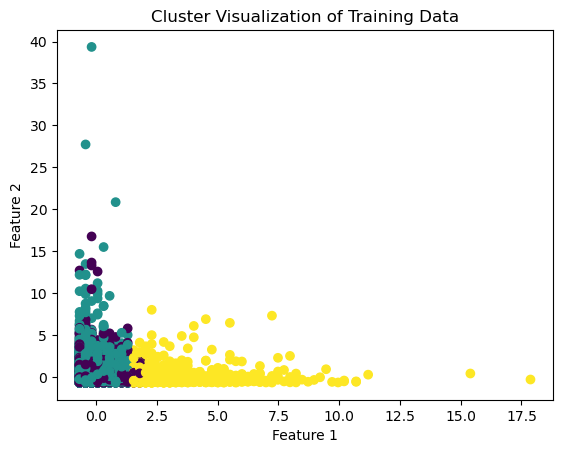

Selected Features for Auto Group (saved in a list): ['12m_call_history', 'ann_prm_amt', 'home_lot_sq_footage', 'household_policy_counts', 'newest_veh_age', 'tenure_at_snapshot', 'geo_group_urban', 'has_prior_carrier_1', 'prdct_sbtyp_grp_C', 'telematics_ind_0']


In [63]:
# Import necessary libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Define a function to preprocess the data
def preprocess_data(df):
    # Handle missing values for specific columns
    non_numeric_columns = df.select_dtypes(include=['object']).columns
    for col in non_numeric_columns:
        df[col] = df[col].replace('missing', np.nan)  # Replace 'missing' with NaN
        df[col].fillna(df[col].mode()[0], inplace=True)  # Fill NaN with mode

    # One-hot encode categorical columns
    df = pd.get_dummies(df, drop_first=True)

    # Ensure all columns are numeric
    assert all(df.dtypes != 'object'), "Not all columns are numeric"

    return df

# Preprocess the auto group
df_auto_processed = preprocess_data(df_auto)

# Separate features (X) and target (y) for the auto group
X_auto = df_auto_processed.drop(columns=['call_counts', 'id'], errors='ignore')  # Adjust based on your column names
y_auto = df_auto_processed['call_counts']

# Function to perform feature selection and train the model
def train_model(X, y):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Perform Recursive Feature Elimination (RFE)
    rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)
    X_rfe_train = rfe.fit_transform(X_train_scaled, y_train)  # Transform training set
    X_rfe_test = rfe.transform(X_test_scaled)  # Transform test set

    # Get selected features and save to list
    selected_features_auto = X.columns[rfe.support_].tolist()  # Save the selected features in a list
    print("Selected Features for Auto Group:", selected_features_auto)

    # Apply K-Means clustering on the selected features
    kmeans = KMeans(n_clusters=3, random_state=42)  # You can adjust the number of clusters based on your data
    kmeans.fit(X_rfe_train)

    # Add the cluster label to the training and test data
    X_train_clustered = pd.DataFrame(X_rfe_train, columns=selected_features_auto)
    X_test_clustered = pd.DataFrame(X_rfe_test, columns=selected_features_auto)
    X_train_clustered['cluster'] = kmeans.labels_
    X_test_clustered['cluster'] = kmeans.predict(X_rfe_test)

    # Calculate the average call count per cluster (for prediction purposes)
    cluster_means = y_train.groupby(kmeans.labels_).mean()

    # Assign predicted call counts based on cluster means
    y_pred_train = X_train_clustered['cluster'].map(cluster_means)
    y_pred_test = X_test_clustered['cluster'].map(cluster_means)

    # Evaluate the model
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))  # Train RMSE
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))  # Test RMSE
    train_r2 = r2_score(y_train, y_pred_train)  # Train R2
    test_r2 = r2_score(y_test, y_pred_test)  # Test R2

    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Train R2: {train_r2:.4f}")
    print(f"Test R2: {test_r2:.4f}")

    # Visualize clusters
    plt.scatter(X_rfe_train[:, 0], X_rfe_train[:, 1], c=kmeans.labels_, cmap='viridis')
    plt.title("Cluster Visualization of Training Data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

    return selected_features_auto, kmeans

# Train and evaluate the model for the auto group
print("Training model for Auto group using Clustering:")
selected_features_auto, kmeans_model = train_model(X_auto, y_auto)

# The list of selected features can now be used
print("Selected Features for Auto Group (saved in a list):", selected_features_auto)


In [69]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import statsmodels.api as sm
from pygam import LinearGAM
from sklearn.linear_model import Lasso
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_auto[selected_features_auto], y_auto, test_size=0.2, random_state=42)

# Ensure all columns in X_train and X_test are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Drop any rows or columns with NaN values if necessary
X_train = X_train.dropna()
X_test = X_test.dropna()

# Add a constant to X for intercept
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)



# Dictionary to store results
results = {}

# Function to evaluate and print metrics
def evaluate_model(model_name, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[model_name] = {'MAE': mae, 'RMSE': rmse}
    print(f"{model_name} Results")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}\n")

# 1. Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred_rf = rf_regressor.predict(X_test)
evaluate_model("Random Forest Regressor", y_test, y_pred_rf)

# 2. XGBoost Regressor
xgb_regressor = XGBRegressor(random_state=42)
xgb_regressor.fit(X_train, y_train)
y_pred_xgb = xgb_regressor.predict(X_test)
evaluate_model("XGBoost Regressor", y_test, y_pred_xgb)


# 3. Lasso Regression
lasso_regressor = Lasso(alpha=0.1, random_state=42)
lasso_regressor.fit(X_train, y_train)
y_pred_lasso = lasso_regressor.predict(X_test)
evaluate_model("Lasso Regression", y_test, y_pred_lasso)

# Display results summary
print("Summary of Results:")
for model_name, metrics in results.items():
    print(f"{model_name} - MAE: {metrics['MAE']}, RMSE: {metrics['RMSE']}")


Random Forest Regressor Results
Mean Absolute Error (MAE): 29.226242892881512
Root Mean Squared Error (RMSE): 37.881550645453665

XGBoost Regressor Results
Mean Absolute Error (MAE): 29.217285345437475
Root Mean Squared Error (RMSE): 38.84162076821881

Lasso Regression Results
Mean Absolute Error (MAE): 28.77439065202204
Root Mean Squared Error (RMSE): 37.33925385246376

Summary of Results:
Random Forest Regressor - MAE: 29.226242892881512, RMSE: 37.881550645453665
XGBoost Regressor - MAE: 29.217285345437475, RMSE: 38.84162076821881
Lasso Regression - MAE: 28.77439065202204, RMSE: 37.33925385246376


In [70]:
from pygam import LinearGAM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import QuantileRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

# Ensure data is dense and cleaned
X_auto_clean = X_auto.fillna(0)
X_auto_dense = X_auto_clean.to_numpy()

# Dictionary to store results
results = {}

# Function to evaluate and print metrics
def evaluate_model(model_name, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[model_name] = {'MAE': mae, 'RMSE': rmse}
    print(f"{model_name} Results")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}\n")

# 1. Generalized Additive Models (GAMs)
def train_gam(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    gam = LinearGAM().fit(X_train, y_train)
    y_pred = gam.predict(X_test)
    evaluate_model("Generalized Additive Model (GAM)", y_test, y_pred)

# 2. Neural Networks
def train_neural_network(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    y_pred = model.predict(X_test).flatten()
    evaluate_model("Neural Network", y_test, y_pred)

# 3. Quantile Regression
def train_quantile_regression(X, y, quantile):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    q_regressor = QuantileRegressor(quantile=quantile, solver='highs')
    q_regressor.fit(X_train, y_train)
    y_pred = q_regressor.predict(X_test)
    evaluate_model(f"Quantile Regression (Quantile: {quantile})", y_test, y_pred)

# Train and evaluate all models
print("Training Generalized Additive Models (GAMs):")
train_gam(X_auto_dense, y_auto)

print("Training Neural Networks:")
train_neural_network(X_auto_dense, y_auto)

print("Training Quantile Regression for Multiple Quantiles:")
train_quantile_regression(X_auto_dense, y_auto, quantile=0.5)  # Median
train_quantile_regression(X_auto_dense, y_auto, quantile=0.75) # 75th Percentile
train_quantile_regression(X_auto_dense, y_auto, quantile=0.25) # 25th Percentile

# Display results summary
print("Summary of Results:")
for model_name, metrics in results.items():
    print(f"{model_name} - MAE: {metrics['MAE']}, RMSE: {metrics['RMSE']}")


Training Generalized Additive Models (GAMs):
Generalized Additive Model (GAM) Results
Mean Absolute Error (MAE): 28.12800408547327
Root Mean Squared Error (RMSE): 36.904650242872265

Training Neural Networks:
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
Neural Network Results
Mean Absolute Error (MAE): 28.90826542908315
Root Mean Squared Error (RMSE): 37.83161615099731

Training Quantile Regression for Multiple Quantiles:
Quantile Regression (Quantile: 0.5) Results
Mean Absolute Error (MAE): 27.196042756424834
Root Mean Squared Error (RMSE): 47.31071835173792

Quantile Regression (Quantile: 0.75) Results
Mean Absolute Error (MAE): 36.94724109326644
Root Mean Squared Error (RMSE): 41.859535357616046

Quantile Regression (Quantile: 0.25) Results
Mean Absolute Error (MAE): 27.196042756424834
Root Mean Squared Error (RMSE): 47.31071835173792

Summary of Results:
Generalized Additive Model (GAM) - MAE: 28.12800408547327, RMSE: 36.904650242872265
Neural Network - MAE: 28.90826542908315, RMSE: 

In [99]:
from pygam import LinearGAM, s
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_auto_dense, y_auto, test_size=0.2, random_state=42)

# Initialize and fit the LinearGAM with tuned parameters
gam = LinearGAM(s(0, n_splines=25, lam=0.1) + s(1, n_splines=25, lam=0.1)).fit(X_train, y_train)

# Predict on the test set
y_pred = gam.predict(X_test)

# Evaluate the updated GAM model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Updated GAM Results")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Visualize the smoothness for each feature
gam.summary()


Updated GAM Results
Mean Absolute Error (MAE): 28.16449057353176
Root Mean Squared Error (RMSE): 36.904512853170324
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     27.8991
Link Function:                     IdentityLink Log Likelihood:                               -141932.4649
Number of Samples:                        17588 AIC:                                           283922.7279
                                                AICc:                                          283922.8263
                                                GCV:                                              1278.414
                                                Scale:                                           1274.7644
                            

In [95]:
from pygam import PoissonGAM, LinearGAM, s
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Log-transform the target variable
y_train_transformed = np.log1p(y_train)
y_test_transformed = np.log1p(y_test)

# Initialize and fit the Poisson GAM with increased regularization
gam = PoissonGAM(s(0, n_splines=25, lam=10) + s(1, n_splines=25, lam=10)).fit(X_train, y_train_transformed)

# Predict and back-transform the predictions
y_pred_transformed = gam.predict(X_test)
y_pred = np.expm1(y_pred_transformed)  # Back-transform to original scale

# Evaluate the revised GAM model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Revised GAM Results")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Summarize the model
gam.summary()


Revised GAM Results
Mean Absolute Error (MAE): 26.107852250874757
Root Mean Squared Error (RMSE): 42.84273778419087
PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     17.9074
Link Function:                          LogLink Log Likelihood:                                -35241.5261
Number of Samples:                        17588 AIC:                                             70518.867
                                                AICc:                                           70518.9099
                                                UBRE:                                               4.4576
                                                Scale:                                                 1.0
                            

In [96]:
from pygam import PoissonGAM, s

# Define parameter grid
lams = np.logspace(-2, 2, 5)       # Try values from 0.01 to 100
splines = [10, 15, 20, 25, 30]     # Different choices for n_splines

# Initialize GAM with grid search
gam = PoissonGAM(s(0) + s(1))
gam.gridsearch(X_train, y_train_transformed, lam=lams, n_splines=splines)

# Evaluate the model
y_pred_transformed = gam.predict(X_test)
y_pred = np.expm1(y_pred_transformed)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Tuned GAM Results")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Model summary
gam.summary()


  0% (0 of 25) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  4% (1 of 25) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:06
  8% (2 of 25) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:07
 12% (3 of 25) |###                      | Elapsed Time: 0:00:01 ETA:   0:00:08
 16% (4 of 25) |####                     | Elapsed Time: 0:00:01 ETA:   0:00:08
 20% (5 of 25) |#####                    | Elapsed Time: 0:00:02 ETA:   0:00:09
 24% (6 of 25) |######                   | Elapsed Time: 0:00:02 ETA:   0:00:08
 28% (7 of 25) |#######                  | Elapsed Time: 0:00:03 ETA:   0:00:07
 32% (8 of 25) |########                 | Elapsed Time: 0:00:03 ETA:   0:00:07
 36% (9 of 25) |#########                | Elapsed Time: 0:00:04 ETA:   0:00:07
 40% (10 of 25) |#########               | Elapsed Time: 0:00:04 ETA:   0:00:07
 44% (11 of 25) |##########              | Elapsed Time: 0:00:05 ETA:   0:00:06
 48% (12 of 25) |###########            

Tuned GAM Results
Mean Absolute Error (MAE): 26.191557592362216
Root Mean Squared Error (RMSE): 42.98999183143892
PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     32.8002
Link Function:                          LogLink Log Likelihood:                                -35210.0177
Number of Samples:                        17588 AIC:                                            70485.6358
                                                AICc:                                           70485.7698
                                                UBRE:                                               4.4562
                                                Scale:                                                 1.0
                              

Training Set: MAE = 27.4128, RMSE = 35.6755
Test Set: MAE = 28.1645, RMSE = 36.9045
No significant overfitting detected.


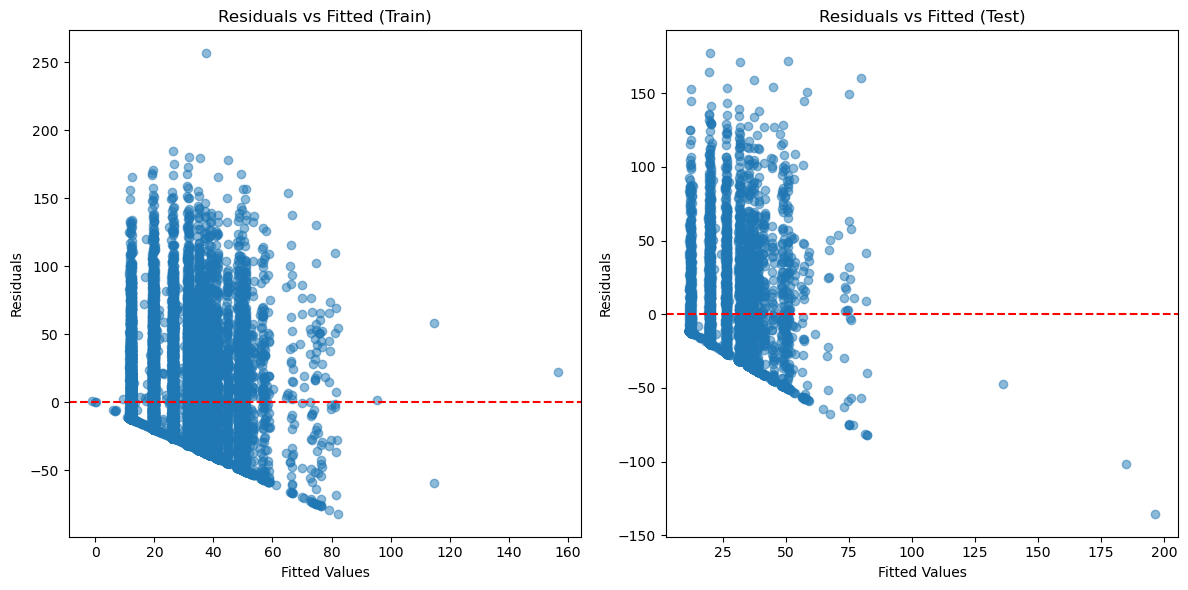

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict on training and test sets using LinearGAM
y_train_pred = gam.predict(X_train)  # Predictions on training set
y_test_pred = gam.predict(X_test)    # Predictions on test set

# Compute evaluation metrics for train and test sets
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training Set: MAE = {train_mae:.4f}, RMSE = {train_rmse:.4f}")
print(f"Test Set: MAE = {test_mae:.4f}, RMSE = {test_rmse:.4f}")

# Check for overfitting
if abs(train_rmse - test_rmse) / train_rmse > 0.1:
    print("Potential Overfitting Detected: Significant performance gap between training and test sets.")
else:
    print("No significant overfitting detected.")

# Residual analysis
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Plot residuals vs fitted values
plt.figure(figsize=(12, 6))

# Residuals for training set
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, train_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted (Train)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

# Residuals for test set
plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, test_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted (Test)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()


Mean Absolute Error (MAE): 28.1645
Root Mean Squared Error (RMSE): 36.9045
R-squared (R²): 0.0912
Mean Absolute Percentage Error (MAPE): inf%


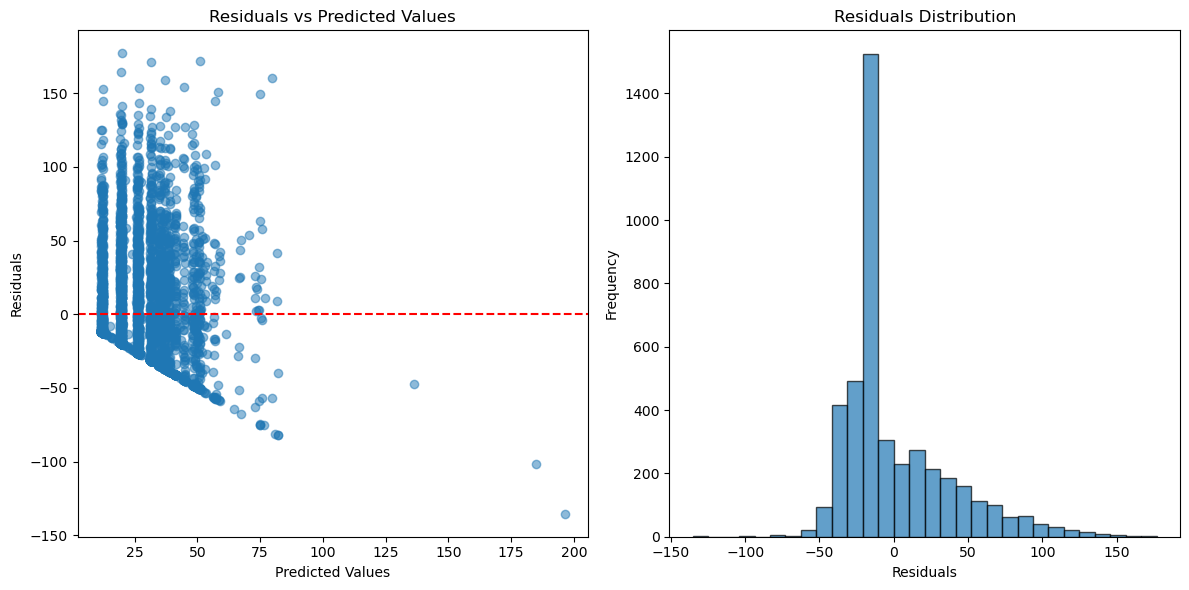

In [94]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Residual analysis
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

# Plot histogram of residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


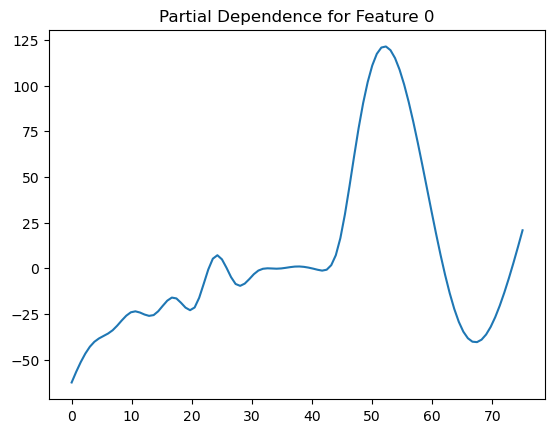

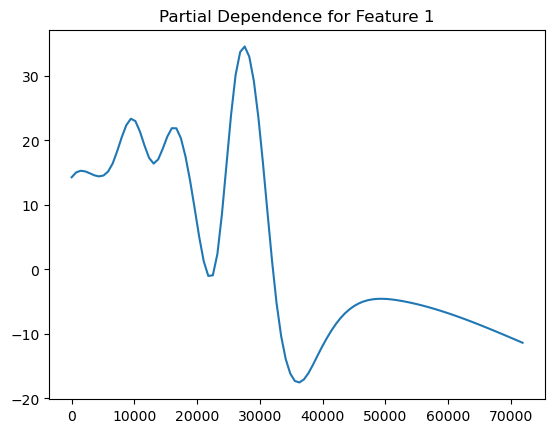

In [101]:
# Plot smooth terms to understand feature effects
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.figure()
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f"Partial Dependence for Feature {i}")
    plt.show()


In [28]:


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# Function to train, evaluate, and perform hyperparameter tuning using GridSearchCV
def train_and_evaluate_with_grid_search(model, param_grid, X_train, y_train, X_test, y_test):
    # Initialize GridSearchCV with 3-fold cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)  # Fit the model

    # Get the best parameters and best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print(f"Best parameters for {model.__class__.__name__}: {best_params}")

    # Predict and evaluate the model
    y_pred = best_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
    r2 = r2_score(y_test, y_pred)  # R-squared score
    print(f"RMSE: {rmse:.4f}")
    print(f"R-squared: {r2:.4f}")
    print("="*50)

    return best_model

# Random Forest Regressor Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestRegressor(random_state=42)

# Perform the hyperparameter tuning and evaluation
train_and_evaluate_with_grid_search(rf_model, rf_param_grid, X_train, y_train, X_test, y_test)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters for RandomForestRegressor: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RMSE: 36.7782
R-squared: 0.0974


RandomForestRegressor(max_depth=3, n_estimators=200, random_state=42)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_auto[selected_features_auto], y_auto, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression Hyperparameter Tuning with RandomizedSearchCV
lr_param_dist = {
    'C': np.logspace(-3, 3, 7),  # Regularization strength (log scale)
    'solver': ['liblinear', 'saga'],  # Solvers for logistic regression
    'penalty': ['l1', 'l2'],  # Both L1 and L2 regularization
    'multi_class': ['ovr'],  # Use 'ovr' (one-vs-rest)
    'max_iter': [100, 500]  # Number of iterations for convergence
}

# Logistic Regression model
lr_model = LogisticRegression(random_state=42, class_weight='balanced')

# RandomizedSearchCV instead of GridSearchCV for faster results
random_search = RandomizedSearchCV(lr_model, lr_param_dist, n_iter=10, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Fit the model on the scaled training data
random_search.fit(X_train_scaled, y_train)

# Get the best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

print(f"Best parameters for Logistic Regression: {best_params}")

# Evaluate the model on the scaled test data
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l1', 'multi_class': 'ovr', 'max_iter': 100, 'C': 0.001}
Accuracy: 0.4862

Classification Report:
               precision    recall  f1-score   support

           0       0.49      1.00      0.65      2138
           1       0.00      0.00      0.00        38
           2       0.00      0.00      0.00        35
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00        33
           5       0.00      0.00      0.00        22
           6       0.00      0.00      0.00        34
           7       0.00      0.00      0.00        27
           8       0.00      0.00      0.00        30
           9       0.00      0.00      0.00        22
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00        20
          12       0.00      0.00      0.00        22
       

# test data

In [30]:

data = pd.read_csv('test_data.csv', delimiter=',')
data.info()

data.head()

#### 2.2.2 column (object to int): tenure_at_snapshot
### acoording to the logic, tenure_at snapshot should also be int
# Identify and display non-numeric values in 'tenure_at_snapshot'
non_numeric_tenure = data[pd.to_numeric(data['tenure_at_snapshot'], errors='coerce').isna() & data['tenure_at_snapshot'].notna()]
print("Non-numeric values in 'tenure_at_snapshot':")
print(non_numeric_tenure)
###there is no non-numeric values, so do the transformation directly

data['tenure_at_snapshot'] = pd.to_numeric(data['tenure_at_snapshot'], errors='coerce').fillna(0).astype(int)
print(data['tenure_at_snapshot'].dtype)
#### 2.2.3 column(int to object) : pol_edeliv_ind
# Convert 'pol_edeliv_ind' from integer to object (string)
data['pol_edeliv_ind'] = data['pol_edeliv_ind'].astype(str)

# Confirm the conversion was successful
print(data['pol_edeliv_ind'].dtype)

#### 2.2.4 column(int to object) : digital_contact_ind
data['digital_contact_ind'] = data['digital_contact_ind'].astype(str)

print(data['digital_contact_ind'].dtype)

#### 2.2.6 column(int to object) : has_prior_carrier
data['has_prior_carrier'] = data['has_prior_carrier'].astype(str)

print(data['has_prior_carrier'].dtype)


data['telematics_ind'] = data['telematics_ind'].astype(str).str.strip()
unique_values = data['telematics_ind'].value_counts()

###2.3 Identify categorical columns and deal with missing value
# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Create a summary DataFrame for each categorical column
summary_dfs = []

for col in categorical_columns:
    # Create a DataFrame for the current column's value counts
    col_summary = data[col].value_counts().reset_index()
    col_summary.columns = [col, 'count']

    # Store the result
    summary_dfs.append(col_summary)

# Display each column's summary
for summary_df in summary_dfs:
    print(f"Unique values and counts for column: {summary_df.columns[0]}")
    print(summary_df)
    print("\n" + "-"*50 + "\n")

#Deal with missing value by using KNN to predict
###########################################################################
###########  Deal with missing value for acq_method column #######
###########################################################################
# Normalization on numeric variables
numerical_columns = ['12m_call_history', 'ann_prm_amt','home_lot_sq_footage','tenure_at_snapshot','newest_veh_age','trm_len_mo','household_policy_counts']


# Data Splitting, valid and invalid acq_method

data_with_acq_info = data[data['acq_method'] != 'missing']
data_without_acq_info = data[data['acq_method'] == 'missing']

# Select numerical columns as features for K-NN
X_train = data_with_acq_info[numerical_columns]
y_train = data_with_acq_info['acq_method']
X_test = data_without_acq_info[numerical_columns]


# Initialize and train K-NN
knn = KNeighborsClassifier(n_neighbors=5)  # Set 'k' value
knn.fit(X_train, y_train)

# Predict acq information for 'missing ' rows
predicted_acq_method = knn.predict(X_test)

# Update the predicted_acq_method column with predicted values
data.loc[data['acq_method'] == 'missing', 'acq_method'] = predicted_acq_method

###########################################################################
###########  Deal with missing value for pol_edeliv_ind column #######
###########################################################################
# Normalization on numeric variables
numerical_columns = ['12m_call_history', 'ann_prm_amt','home_lot_sq_footage','tenure_at_snapshot','newest_veh_age','trm_len_mo','household_policy_counts']


# Data Splitting, valid and invalid pol_edeliv_method

data_with_pol_edeliv_info = data[data['pol_edeliv_ind'] != '-2']
data_without_pol_edeliv_info = data[data['pol_edeliv_ind'] == '-2']

# Select numerical columns as features for K-NN
X_train = data_with_pol_edeliv_info[numerical_columns]
y_train = data_with_pol_edeliv_info['pol_edeliv_ind']
X_test = data_without_pol_edeliv_info[numerical_columns]


# Initialize and train K-NN
knn = KNeighborsClassifier(n_neighbors=5)  # Set 'k' value
knn.fit(X_train, y_train)

# Predict pol_edeliv information for 'missing ' rows
predicted_pol_edeliv_method = knn.predict(X_test)

# Update the predicted_pol_edeliv_method column with predicted values
data.loc[data['pol_edeliv_ind'] == '-2','pol_edeliv_ind'] = predicted_pol_edeliv_method
# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Create a summary DataFrame for each categorical column
summary_dfs = []

for col in categorical_columns:
    # Create a DataFrame for the current column's value counts
    col_summary = data[col].value_counts().reset_index()
    col_summary.columns = [col, 'count']

    # Store the result
    summary_dfs.append(col_summary)

# Display each column's summary
for summary_df in summary_dfs:
    print(f"Unique values and counts for column: {summary_df.columns[0]}")
    print(summary_df)
    print("\n" + "-"*50 + "\n")




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       20000 non-null  int64  
 1   12m_call_history         20000 non-null  int64  
 2   acq_method               20000 non-null  object 
 3   ann_prm_amt              20000 non-null  float64
 4   bi_limit_group           20000 non-null  object 
 5   channel                  20000 non-null  object 
 6   digital_contact_ind      20000 non-null  int64  
 7   geo_group                20000 non-null  object 
 8   has_prior_carrier        20000 non-null  int64  
 9   home_lot_sq_footage      20000 non-null  int64  
 10  household_group          20000 non-null  object 
 11  household_policy_counts  20000 non-null  int64  
 12  newest_veh_age           20000 non-null  int64  
 13  pay_type_code            20000 non-null  object 
 14  pol_edeliv_ind        

In [31]:
df_1dwelling = data[data['household_group'] == '1dwelling']
df_2autodwelling = data[data['household_group'] == '2autodwelling']
df_3other = data[data['household_group'] == '3other']
df_3autodwellingumb = data[data['household_group'] == '3autodwellingumb']

# Print the shape of each DataFrame to confirm the split
print(f"1dwelling: {df_1dwelling.shape}")
print(f"2autodwelling: {df_2autodwelling.shape}")
print(f"3other: {df_3other.shape}")
print(f"3autodwellingumb: {df_3autodwellingumb.shape}")

1dwelling: (12335, 21)
2autodwelling: (5065, 21)
3other: (2155, 21)
3autodwellingumb: (445, 21)


In [32]:
# For '1dwelling'
df_1dwelling_nonauto = df_1dwelling[df_1dwelling['newest_veh_age'] == -20]
df_1dwelling_auto = df_1dwelling[df_1dwelling['newest_veh_age'] != -20]

# For '2autodwelling'
df_2autodwelling_nonauto = df_2autodwelling[df_2autodwelling['newest_veh_age'] == -20]
df_2autodwelling_auto = df_2autodwelling[df_2autodwelling['newest_veh_age'] != -20]

# For '3other'
df_3other_nonauto = df_3other[df_3other['newest_veh_age'] == -20]
df_3other_auto = df_3other[df_3other['newest_veh_age'] != -20]

# For '3autodwellingumb'
df_3autodwellingumb_nonauto = df_3autodwellingumb[df_3autodwellingumb['newest_veh_age'] == -20]
df_3autodwellingumb_auto = df_3autodwellingumb[df_3autodwellingumb['newest_veh_age'] != -20]

# Step 3: Print the shapes to confirm the splits
print(f"1dwelling - Non-Auto: {df_1dwelling_nonauto.shape}, Auto: {df_1dwelling_auto.shape}")
print(f"2autodwelling - Non-Auto: {df_2autodwelling_nonauto.shape}, Auto: {df_2autodwelling_auto.shape}")
print(f"3other - Non-Auto: {df_3other_nonauto.shape}, Auto: {df_3other_auto.shape}")
print(f"3autodwellingumb - Non-Auto: {df_3autodwellingumb_nonauto.shape}, Auto: {df_3autodwellingumb_auto.shape}")

1dwelling - Non-Auto: (12335, 21), Auto: (0, 21)
2autodwelling - Non-Auto: (0, 21), Auto: (5065, 21)
3other - Non-Auto: (2155, 21), Auto: (0, 21)
3autodwellingumb - Non-Auto: (0, 21), Auto: (445, 21)


In [33]:
import pandas as pd

df_auto_test = pd.concat([df_2autodwelling_auto, df_3autodwellingumb_auto])
df_non_auto_test = pd.concat([df_1dwelling_nonauto, df_3other_nonauto])
df_non_auto_test = df_non_auto_test[df_non_auto_test['newest_veh_age'] != 20]


print(f"Auto group shape: {df_auto_test.shape}")
print(f"Non-Auto group shape: {df_non_auto_test.shape}")

Auto group shape: (5510, 21)
Non-Auto group shape: (14490, 21)


# predict data

In [34]:
####try to train auto data####

# Import necessary libraries for LinearGAM
from pygam import LinearGAM

# Function to preprocess and align test data with selected features
def preprocess_and_align_test_data(test_data, selected_features):
    # Preprocess test data
    test_data_processed = preprocess_data(test_data)
    # Align columns with selected features
    test_data_aligned = test_data_processed.reindex(columns=selected_features, fill_value=0)
    return test_data_aligned

# Step 1: Preprocess and align test data
X_test_data_non_auto = preprocess_and_align_test_data(df_non_auto_test, selected_features_non_auto)

# Step 2: Train LinearGAM on the selected features
# Note: X_auto and y_auto were used during feature selection for training
X_auto_selected = X_auto[selected_features_auto]  # Use selected features from training
gam_model = LinearGAM().fit(X_auto_selected, y_auto)  # Train GAM on the selected features

# Step 3: Predict on test data
X_test_data_dense_non_auto = X_test_data_non_auto.to_numpy()  # Convert to dense format for GAM
y_test_pred_non_auto = gam_model.predict(X_test_data_dense_non_auto)

# Step 4: Add predictions to the test data
df_non_auto_test['predicted_call_counts'] = y_test_pred_non_auto

# Step 5: Save predictions to a CSV file
df_non_auto_test.to_csv('try_non_auto.csv', index=False)

# Display the first few rows of the test data with predictions
print("Predictions on Non-Auto Test Data:")
print(df_non_auto_test[['id', 'predicted_call_counts']].head())



Predictions on Non-Auto Test Data:
   id  predicted_call_counts
0   1                  60.75
3   4                  19.68
5   6                  17.52
6   7                   8.22
8   9                  39.36


In [35]:
####try to train non auto data####

# Import necessary libraries for LinearGAM
from pygam import LinearGAM

# Function to preprocess and align test data with selected features
def preprocess_and_align_test_data(test_data, selected_features):
    # Preprocess test data
    test_data_processed = preprocess_data(test_data)
    # Align columns with selected features
    test_data_aligned = test_data_processed.reindex(columns=selected_features, fill_value=0)
    return test_data_aligned

# Step 1: Preprocess and align test data
X_test_data = preprocess_and_align_test_data(df_non_auto_test, selected_features_non_auto)

# Step 2: Train LinearGAM on the selected features
# Note: X_auto and y_auto were used during feature selection for training
X_non_auto_selected = X_non_auto[selected_features_non_auto]  # Use selected features from training
gam_model = LinearGAM().fit(X_non_auto_selected, y_non_auto)  # Train GAM on the selected features

# Step 3: Predict on test data
X_test_data_dense = X_test_data.to_numpy()  # Convert to dense format for GAM
y_test_pred = gam_model.predict(X_test_data_dense)

# Step 4: Add predictions to the test data
df_non_auto_test['predicted_call_counts'] = y_test_pred

# Step 5: Save predictions to a CSV file
df_non_auto_test.to_csv('try_non_auto.csv', index=False)

# Display the first few rows of the test data with predictions
print("Predictions on Test Data:")
print(df_non_auto_test[['id', 'predicted_call_counts']].head())

Predictions on Test Data:
   id  predicted_call_counts
0   1                  33.15
3   4                  21.01
5   6                  20.61
6   7                  12.81
8   9                  42.55
